In [1]:
#code adapted from https://keras.io/examples/vision/grad_cam/

In [1]:
#use gpu:1
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [11]:
from tensorflow.keras.models import Model
import tensorflow as tf

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121, Xception

model_dir = "../RadImageNet/models/RadImageNet-InceptionV3_notop.h5"
img_size = 512
base_model = InceptionV3(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir, pooling='avg')
base_model.summary()

#visualize the model using visualkeras, with legend labels
import visualkeras as vk
from PIL import ImageFont
#increase the font size
font = ImageFont.truetype("arial.ttf", 40)
vk.layered_view(base_model, scale_xy=10, scale_z=1, max_z=2, type_ignore=['GlobalAveragePooling2D', 'Concatenate'], legend=True, font=font)


In [20]:
#remove the last layer
# model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [18]:
import numpy as np
from tensorflow import keras

# Make model
model = keras.models.load_model('models/InceptionV3_radimagenet.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [19]:
inceptionv3_layers = model.get_layer('inception_v3')

In [20]:
inceptionv3_layers.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [21]:
#now we will use GradCAM to visualize the model's attention on the images
def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
find_target_layer(inceptionv3_layers)

'mixed10'

In [36]:
last_conv_layer_name = 'mixed9_1'

In [37]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

preprocess_input = keras.applications.inception_v3.preprocess_input

img_size = (512, 512)
# The local path to our target image
img_path = '../data/jpg/1/9.jpg'
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [38]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [39]:
#remove the top of the model
grad_model = tf.keras.models.Model(
    [inceptionv3_layers.inputs], [inceptionv3_layers.get_layer(last_conv_layer_name).output, inceptionv3_layers.output])
grad_model

In [40]:
# Print what the top predicted class is
preds = model.predict(img_array)
preds


1/1 [==============================] - 0s 70ms/step


array([[0.21250018]], dtype=float32)

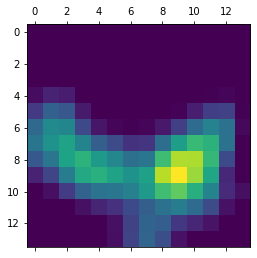

In [41]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, inceptionv3_layers, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

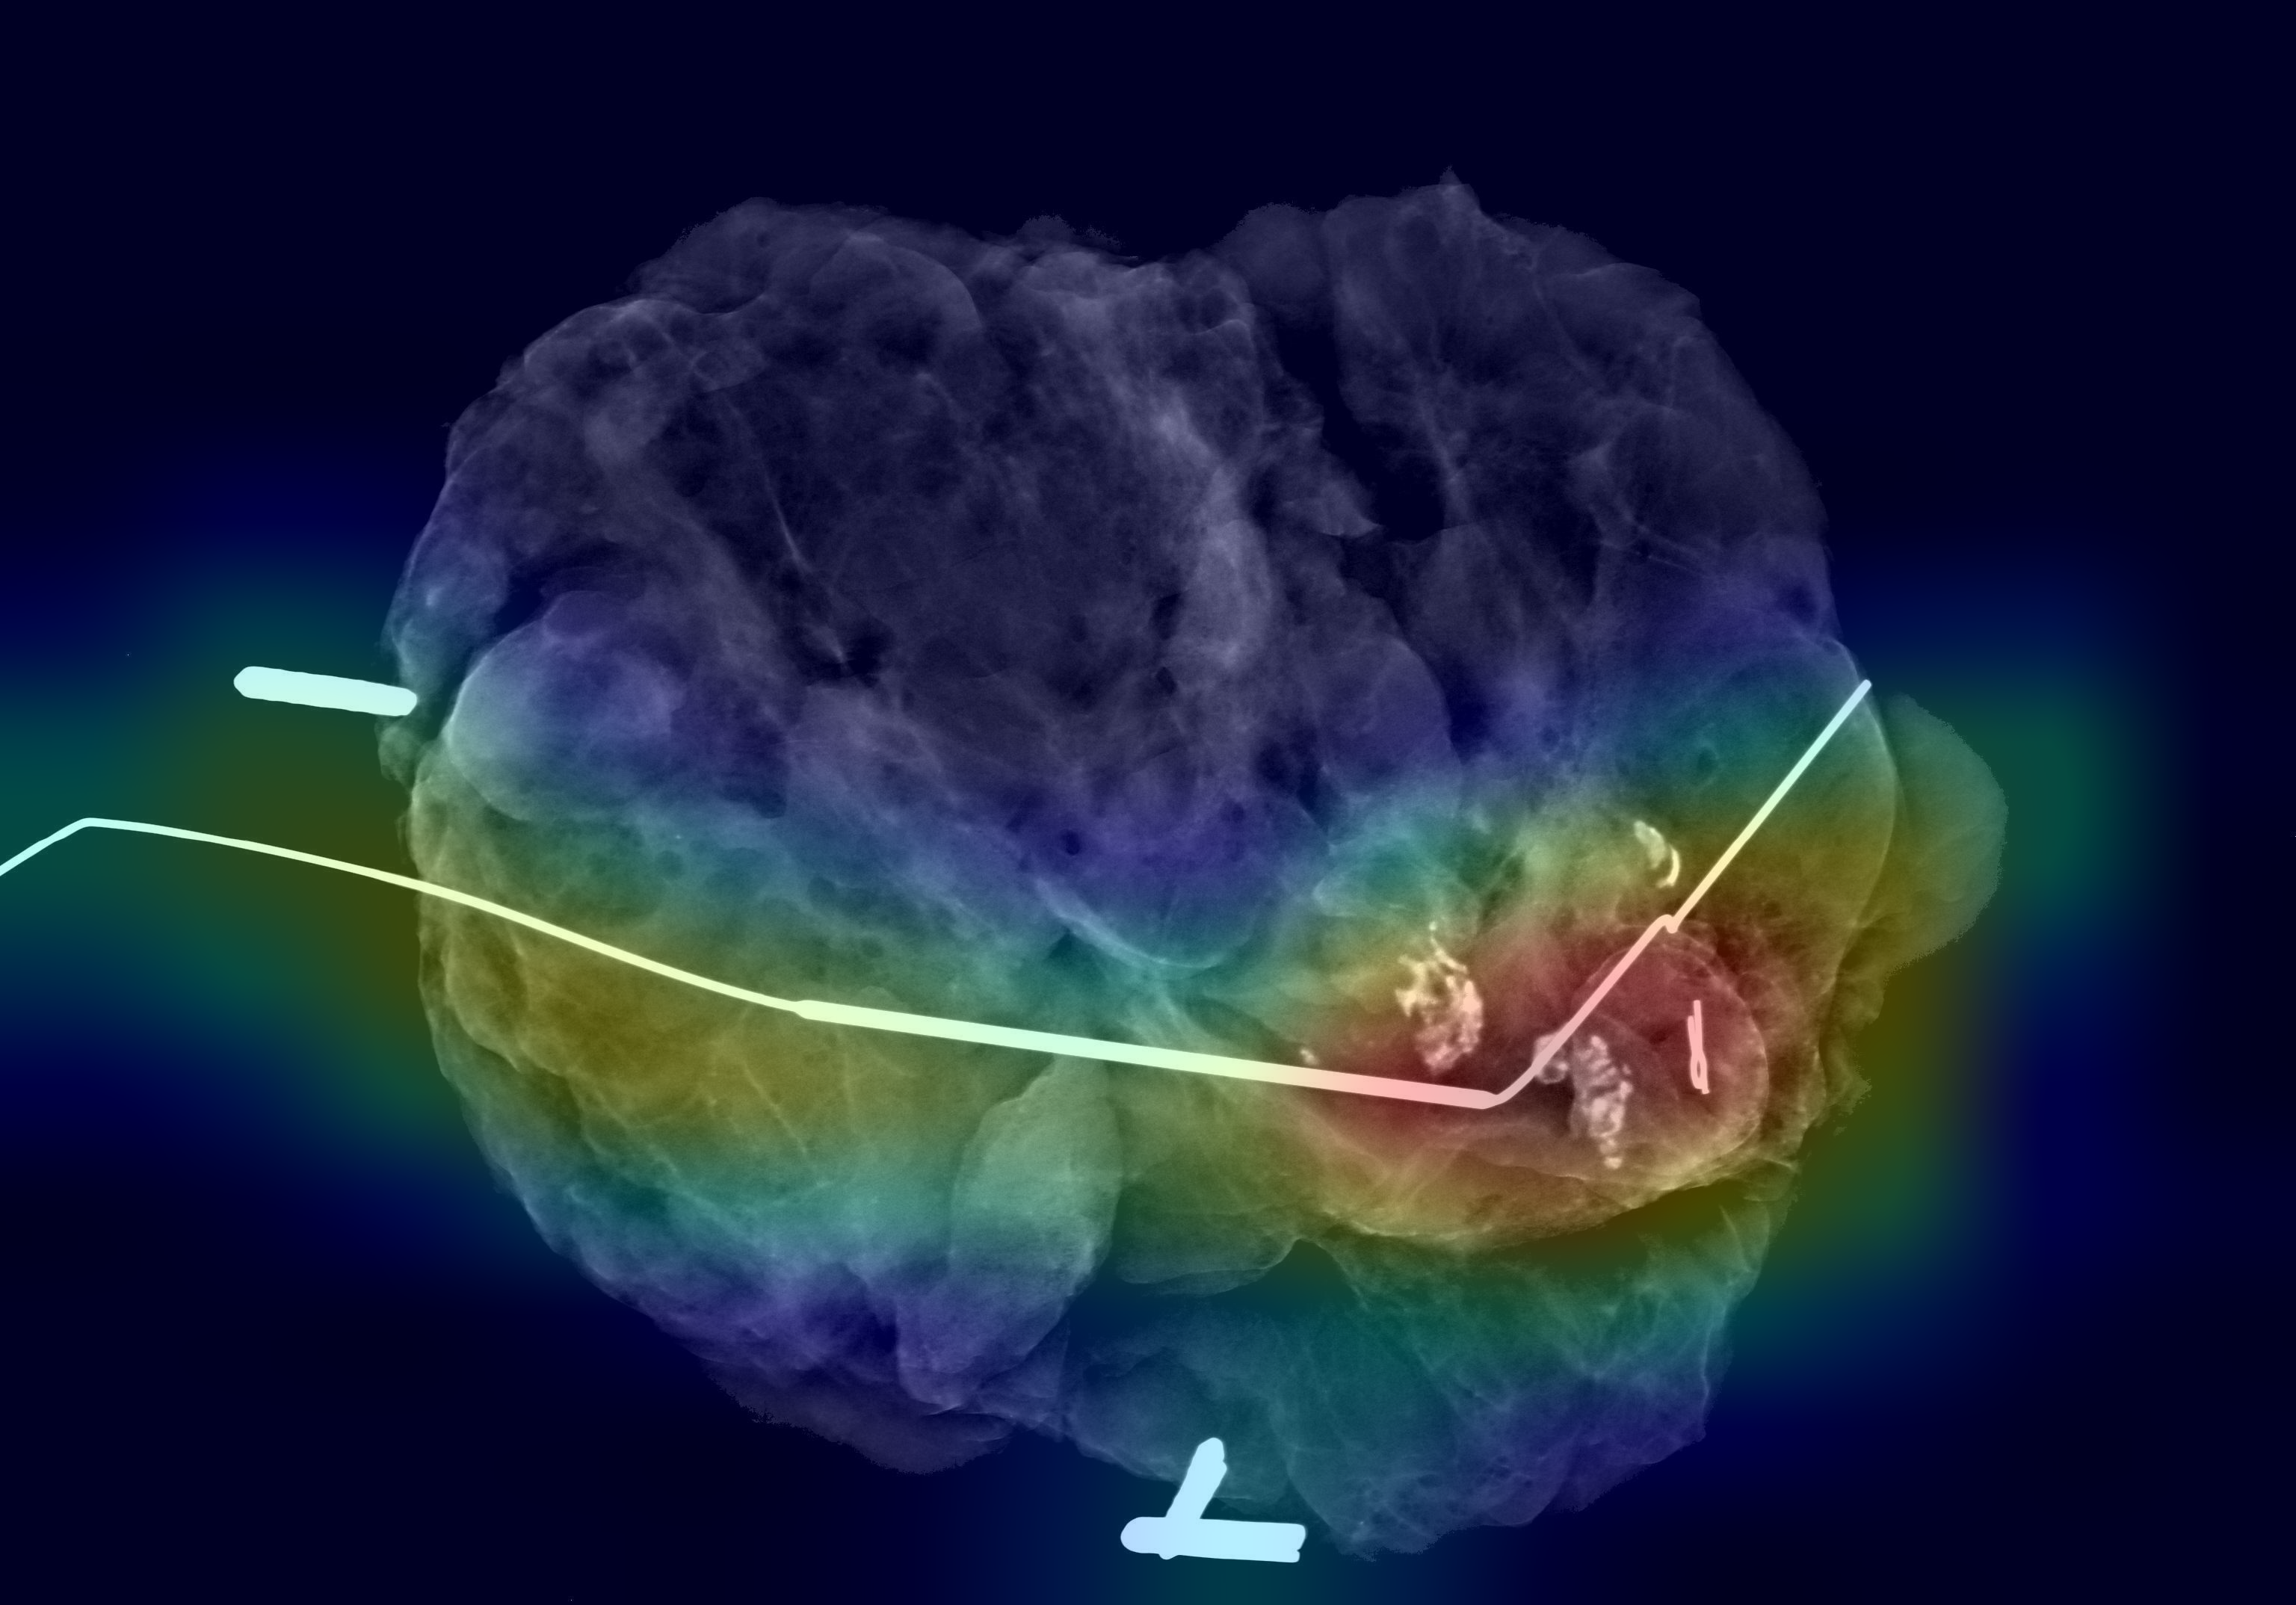

In [43]:

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save('../results/gradcam_iv3.jpg')
    display(superimposed_img)
    

save_and_display_gradcam(img_path, heatmap)